In [58]:
# common
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# third party
## None

# original
from testing_framework.tests import test_algorithm
from arms.bernoulli import BernoulliArm
from algorithms.epsilon_greedy.standard import EpsilonGreedy
from algorithms.softmax.standard import Softmax
from algorithms.ucb.ucb1 import UCB1

# set seed
SEED = 19930219
random.seed(SEED)

In [18]:
# settings
## arms
prob_rewards = [.1, .1, .1, .1, .9]
n_arms = len(prob_rewards)
random.shuffle(prob_rewards)
ind_best_arm = np.argmax(prob_rewards)
arms = list(map(lambda prob: BernoulliArm(prob), prob_rewards))

## sims
num_sims = 5000
horizon = 250

In [19]:
# test epsilon greedy
epsilons  = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] # epsilon = 0.0 means AB testing
##
prob_select_best_by_epsilon = []
reward_by_epsilon = []
cum_reward_by_epsilon = []
for epsilon in epsilons:
    algo = EpsilonGreedy(epsilon, [], [])
    algo.initialize(n_arms)
    res = test_algorithm(algo, arms, num_sims, horizon)
    ##
    ind_selected_arm = np.array(res[2]).reshape(num_sims, -1)
    reward_at_time = np.array(res[3]).reshape(num_sims, -1)
    cum_reward_at_time = np.array(res[4]).reshape(num_sims, -1)

    prob_select_best = np.mean(ind_selected_arm == ind_best_arm, axis = 0)
    reward_at_time = np.mean(reward_at_time, axis = 0)
    cum_reward_at_time = np.mean(cum_reward_at_time, axis = 0)

    prob_select_best_by_epsilon.append(prob_select_best)
    reward_by_epsilon.append(reward_at_time)
    cum_reward_by_epsilon.append(cum_reward_at_time)

algo_name = algo.__class__.__name__

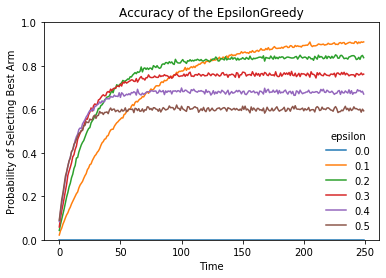

In [20]:
# ベストなアームを選ぶ確率
for i, epsilon in enumerate(epsilons):
    plt.plot(prob_select_best_by_epsilon[i], label=epsilon)

plt.title('Accuracy of the {}'.format(algo_name))
plt.xlabel('Time')
plt.ylabel('Probability of Selecting Best Arm')
plt.ylim([0., 1.])
plt.legend(title = 'epsilon', frameon = False)
plt.show()

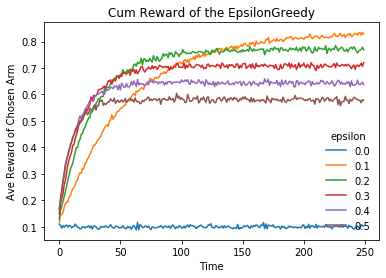

In [21]:
# 各試行において得られる報酬の推移
for i, epsilon in enumerate(epsilons):
    plt.plot(reward_by_epsilon[i], label=epsilon)

plt.title('Cum Reward of the {}'.format(algo_name))
plt.xlabel('Time')
plt.ylabel('Ave Reward of Chosen Arm')
plt.legend(title = 'epsilon', frameon = False)
plt.show()

## 示唆
### hogehoge

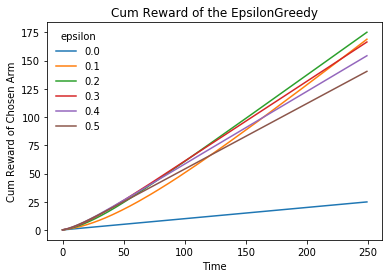

In [22]:
# 各試行において得られる累積報酬の推移
for i, epsilon in enumerate(epsilons):
    plt.plot(cum_reward_by_epsilon[i], label=epsilon)

plt.title('Cum Reward of the {}'.format(algo_name))
plt.xlabel('Time')
plt.ylabel('Cum Reward of Chosen Arm')
plt.legend(title = 'epsilon', frameon = False)
plt.show()

## 示唆
### hogehoge

In [35]:
# softmax
## 推定値が異なるアームに対しては、epsilon greedyでは探索する時に潜在的な損失がある。
## そこで、アームの推定値に関する既知の情報を、アームの選択時に組み込む。
temperatures = [t / 10. for t in range(1, 6)]

prob_select_best_by_temp = []
reward_by_temp = []
cum_reward_by_temp = []
for temperature in temperatures:
    algo = Softmax(temperature, [], [])
    algo.initialize(n_arms)
    res = test_algorithm(algo, arms, num_sims, horizon)
    ind_selected_arm = np.array(res[2]).reshape(num_sims, -1)
    reward_at_time = np.array(res[3]).reshape(num_sims, -1)
    cum_reward_at_time = np.array(res[4]).reshape(num_sims, -1)

    prob_select_best = np.mean(ind_selected_arm == ind_best_arm, axis = 0)
    reward_at_time = np.mean(reward_at_time, axis = 0)
    cum_reward_at_time = np.mean(cum_reward_at_time, axis = 0)

    prob_select_best_by_temp.append(prob_select_best)
    reward_by_temp.append(reward_at_time)
    cum_reward_by_temp.append(cum_reward_at_time)

algo_name = algo.__class__.__name__

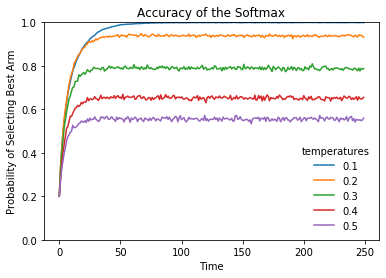

In [36]:
# ベストなアームを選ぶ確率
for i, temp in enumerate(temperatures):
    plt.plot(prob_select_best_by_temp[i], label=temp)

plt.title('Accuracy of the {}'.format(algo_name))
plt.xlabel('Time')
plt.ylabel('Probability of Selecting Best Arm')
plt.ylim([0., 1.])
plt.legend(title = 'temperatures', frameon = False)
plt.show()

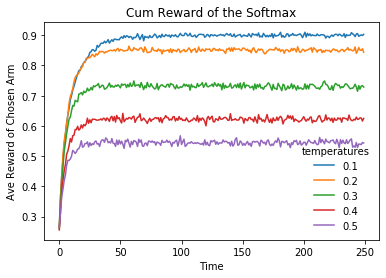

In [37]:
# 各試行において得られる報酬の推移
for i, temp in enumerate(temperatures):
    plt.plot(reward_by_temp[i], label=temp)

plt.title('Cum Reward of the {}'.format(algo_name))
plt.xlabel('Time')
plt.ylabel('Ave Reward of Chosen Arm')
plt.legend(title = 'temperatures', frameon = False)
plt.show()

## 示唆
### hogehoge

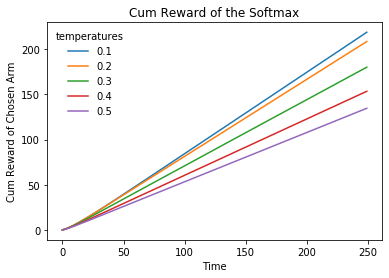

In [54]:
# 各試行において得られる累積報酬の推移
for i, temp in enumerate(temperatures):
    plt.plot(cum_reward_by_temp[i], label=temp)

plt.title('Cum Reward of the {}'.format(algo_name))
plt.xlabel('Time')
plt.ylabel('Cum Reward of Chosen Arm')
plt.legend(title = 'temperatures', frameon = False)
plt.show()

## 示唆
### 温度が小さい0.1のときの戦略がベストであることがわかる。
### softmaxにおいては、温度が低いと探索が少なくなる。
### 殊、今回のように、アーム間の期待報酬の差異が大きい設定では、
### 早めに探索を切り上げて、活用することで累積報酬話を最大化できる。

In [64]:
## UCB
## たまたまよかった、たまたま悪かった場合にepsilon-greedyやsoftmaxは弱い
## この問題を、そのアームに何回探索したかを考慮することで克服したのがUCB
### メリット：設定するパラメータが必要ない。
### デメリット：報酬が[0, 1]の間にはいるように調整が必要。全てのアームを必ず試すので、限られた試行回数とアームの数が近い場合は、初期化ばかりして終わってしまうかもしれない。（残りのプレイ数が多い時に有効）

# ucb1
algo = UCB1([], [])
algo.initialize(n_arms)
res = test_algorithm(algo, arms, num_sims, horizon)
ind_selected_arm = np.array(res[2]).reshape(num_sims, -1)
reward_at_time = np.array(res[3]).reshape(num_sims, -1)
cum_reward_at_time = np.array(res[4]).reshape(num_sims, -1)

prob_select_best = np.mean(ind_selected_arm == ind_best_arm, axis = 0)
reward_at_time = np.mean(reward_at_time, axis = 0)
cum_reward_at_time = np.mean(cum_reward_at_time, axis = 0)

algo_name = algo.__class__.__name__

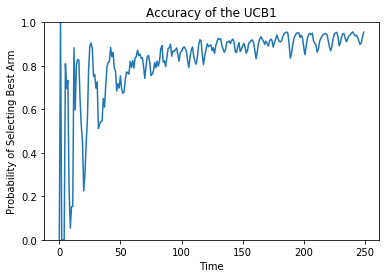

In [65]:
# ベストなアームを選ぶ確率
plt.plot(prob_select_best)
plt.title('Accuracy of the {}'.format(algo_name))
plt.xlabel('Time')
plt.ylabel('Probability of Selecting Best Arm')
plt.ylim([0., 1.])
plt.show()

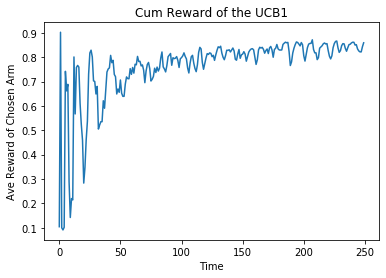

In [66]:
# 各試行において得られる報酬の推移
plt.plot(reward_at_time)
plt.title('Cum Reward of the {}'.format(algo_name))
plt.xlabel('Time')
plt.ylabel('Ave Reward of Chosen Arm')
plt.show()

## 示唆
### hogehoge

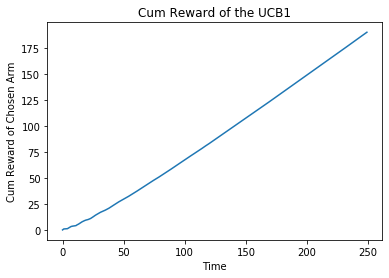

In [67]:
# 各試行において得られる累積報酬の推移
plt.plot(cum_reward_at_time)
plt.title('Cum Reward of the {}'.format(algo_name))
plt.xlabel('Time')
plt.ylabel('Cum Reward of Chosen Arm')
plt.show()

## 示唆
### 温度が小さい0.1のときの戦略がベストであることがわかる。
### softmaxにおいては、温度が低いと探索が少なくなる。
### 殊、今回のように、アーム間の期待報酬の差異が大きい設定では、
### 早めに探索を切り上げて、活用することで累積報酬話を最大化できる。